In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

from sklearn.preprocessing import PowerTransformer

In [2]:
import ipywidgets as widgets
from IPython.display import display
import os

box_layout = widgets.Layout(
    display="flex",
    flex_flow="column",
    align_items="center",
    border="1px solid #E0E0E0",
    width="400px",
    padding="25px",
    border_radius="10px"
)

button_layout = widgets.Layout(width="100%", height="40px")

upload_layout = widgets.Layout(width="100%")

title = widgets.HTML(
    "<h3 style='margin-bottom:10px;'>Upload CSV Files 👇</h3>"
)

subtitle = widgets.HTML(
    "<p style='color:gray; margin-top:0;'>Select one or more CSV files to upload and save</p>"
)

train_uploader = widgets.FileUpload(
    accept='.csv',
    multiple=True,
    layout=upload_layout
)

save_button = widgets.Button(
    description='Save Files',
    button_style='primary',
    icon='save',
    layout=button_layout
)

status = widgets.HTML("<p style='color:gray;'>Waiting for upload...</p>")

output = widgets.Output()

def save_files(change=None):
    with output:
        output.clear_output()
        
        if train_uploader.value:
            saved_files = []
            for filename, file_info in train_uploader.value.items():
                with open(filename, "wb") as f:
                    f.write(file_info['content'])
                saved_files.append(filename)
            
            status.value = f"<p style='color:green;'>Saved {len(saved_files)} file(s) 👍</p>"
        else:
            status.value = "<p style='color:red;'>⚠️ No files uploaded yet</p>"

train_uploader.observe(save_files, names='value')

save_button.on_click(save_files)

card = widgets.VBox(
    [title, subtitle, train_uploader, save_button, status],
    layout=box_layout
)

display(card)
display(output)

Output()

In [3]:
df = pd.read_csv('file.csv')

In [4]:
df.sample(3)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
327,252.3,0.0,98.8,146.3,14.2,987.8,889.0,56,55.83
583,210.7,316.1,0.0,185.7,0.0,977.0,689.3,28,37.81
335,275.1,0.0,121.4,159.5,9.9,1053.6,777.5,14,38.77


In [5]:
df.isnull().sum()

,0
Cement,0
Blast Furnace Slag,0
Fly Ash,0
Water,0
Superplasticizer,0
Coarse Aggregate,0
Fine Aggregate,0
Age,0
Strength,0


### **Train Test Split**

In [6]:
x = df.drop(columns=['Strength'])
y = df.iloc[:, -1]

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(
    x,
    y,
    train_size=0.2,
    random_state=42
)

### **No transformation**

#### **Applying regression**

In [8]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)

ypred = lr.predict(xtest)
r2_score(ytest, ypred)

0.5898641487692848

#### **Cross validation**

In [10]:
lr = LinearRegression()
np.mean(cross_val_score(lr,x,y,scoring='r2'))

np.float64(0.46099404916628606)

### **Distplots without transformation**

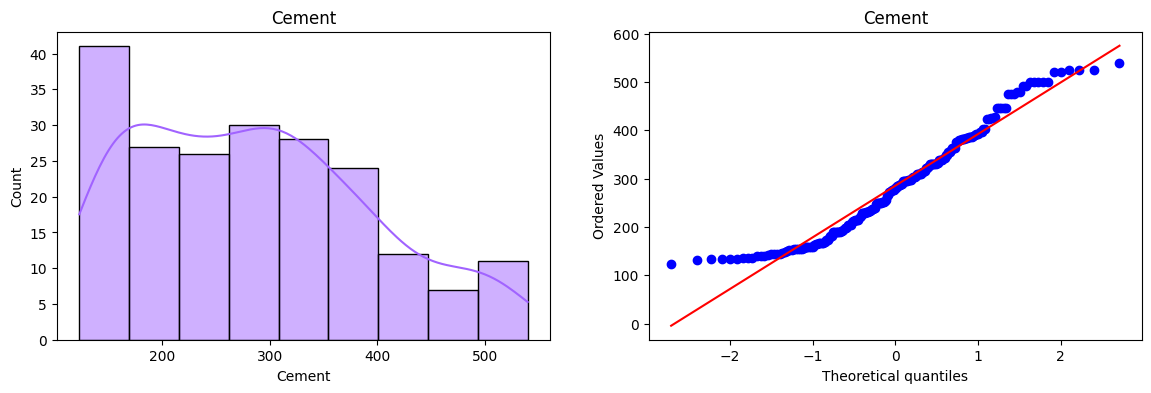

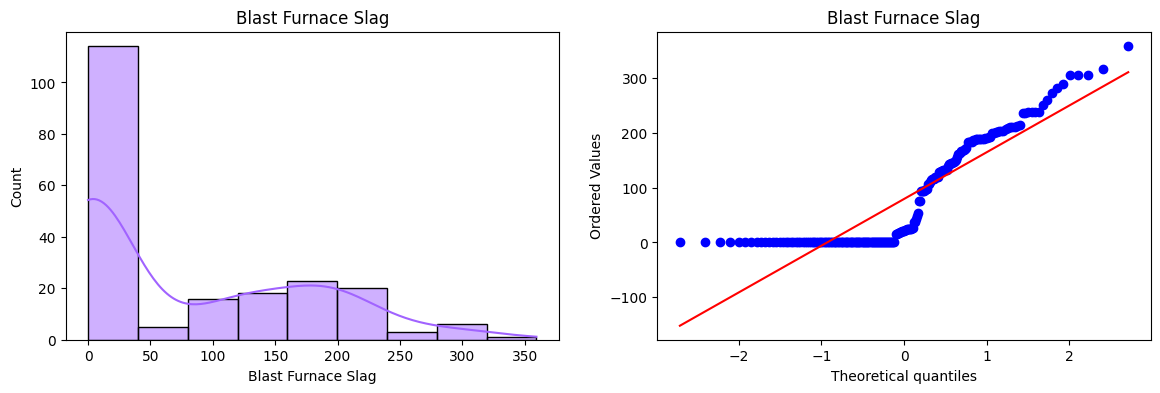

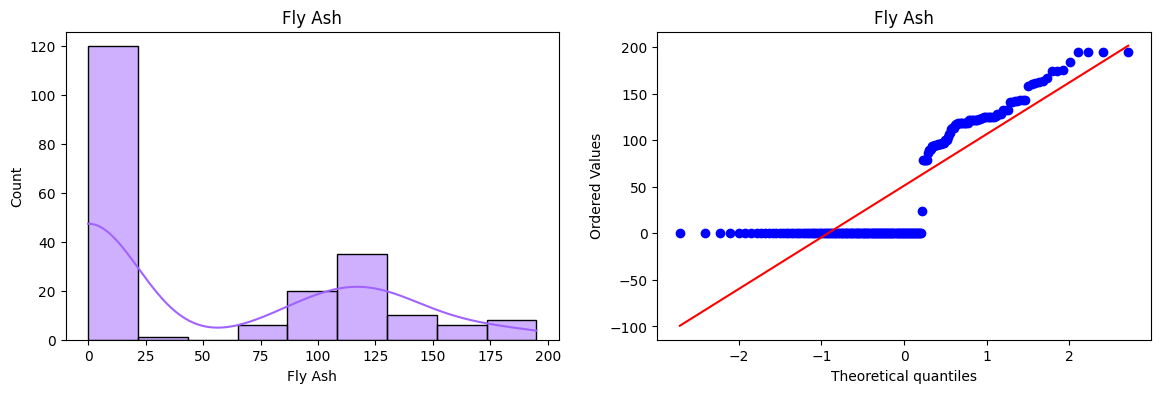

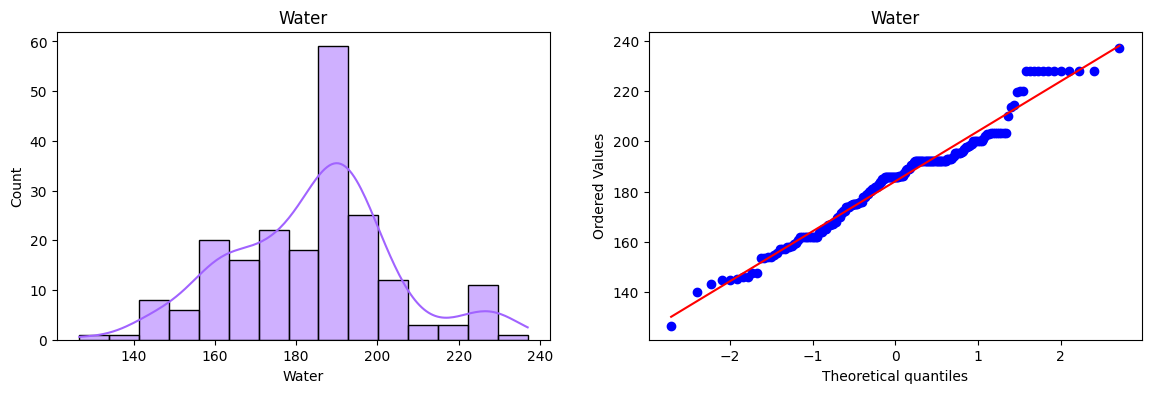

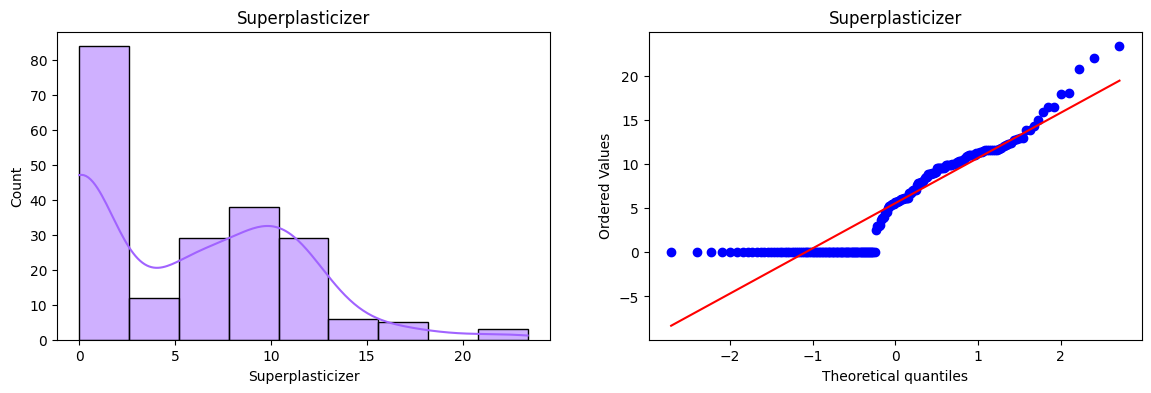

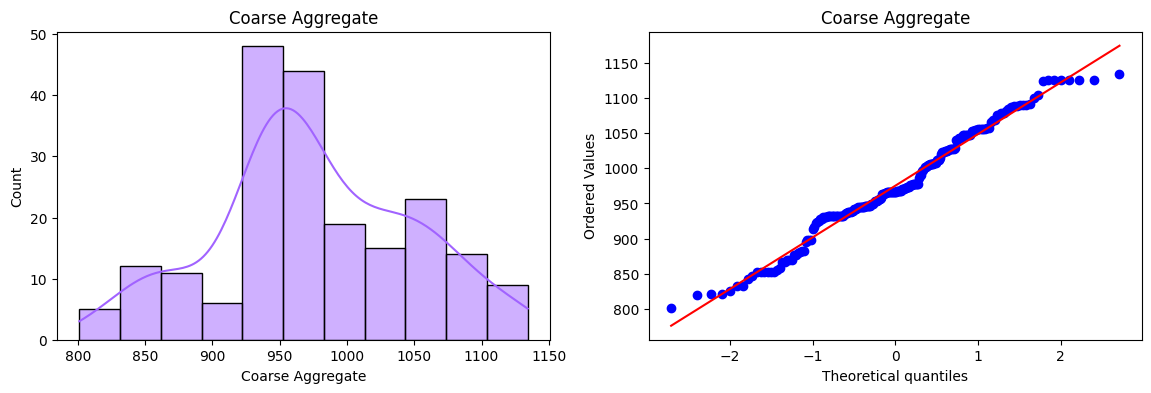

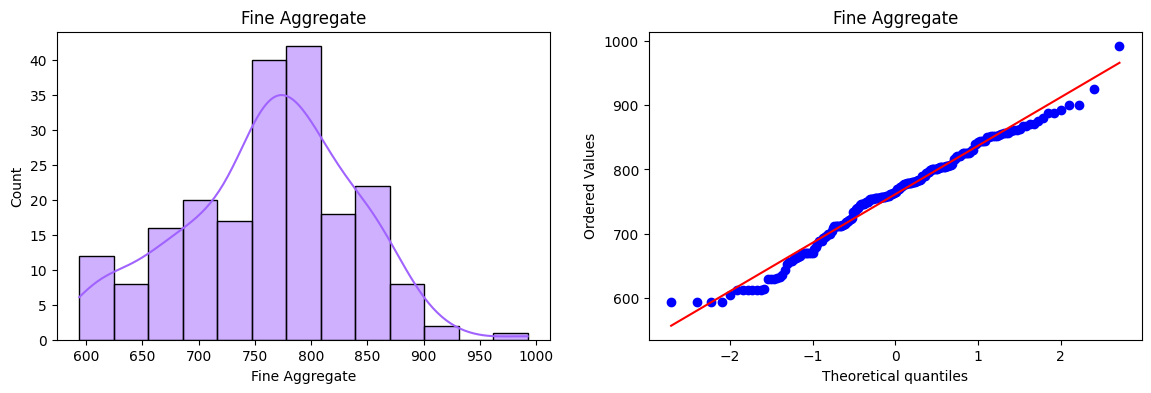

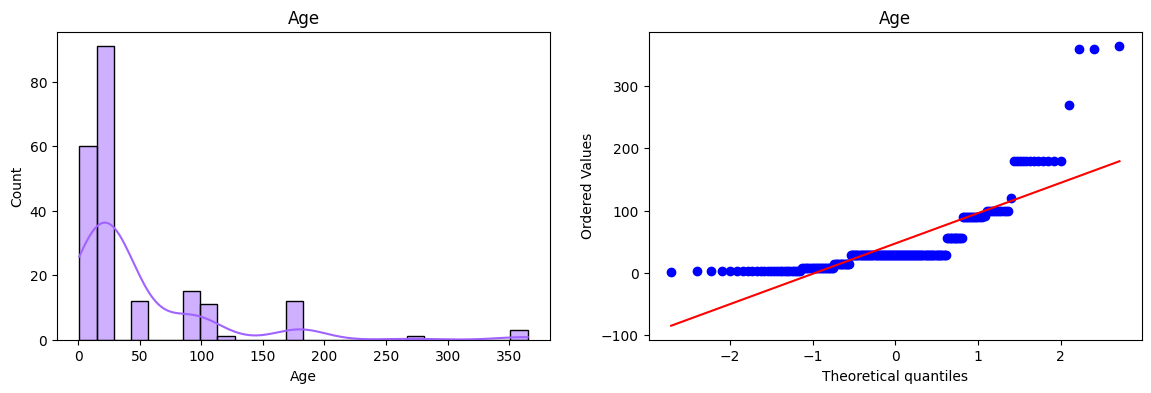

In [13]:
for col in xtrain.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.histplot(xtrain[col], color="#A163FF", kde=True)
    plt.title(col)

    plt.subplot(122)
    stats.probplot(xtrain[col], dist="norm", plot=plt)
    plt.title(col)

    plt.show() 

### **Using box cox transformer**

In [14]:
pt = PowerTransformer(method='box-cox')

xtrain_transformed = pt.fit_transform(xtrain + 0.0000001)
xtest_transformed = pt.fit_transform(xtest + 0.0000001)

pd.DataFrame({'columns':xtrain.columns, 'lambda_values':pt.lambdas_})

,columns,lambda_values
0,Cement,0.171071
1,Blast Furnace Slag,0.022881
2,Fly Ash,-0.024016
3,Water,0.785994
4,Superplasticizer,0.094153
5,Coarse Aggregate,1.172120
6,Fine Aggregate,1.887682
7,Age,0.042472


##### **Linear regression on transformed data**

In [15]:
lr.fit(xtrain_transformed, ytrain)
ypred_new = lr.predict(xtest_transformed)

r2_score(ytest, ypred_new)

0.7985099251680902

### **Before & After comparison**

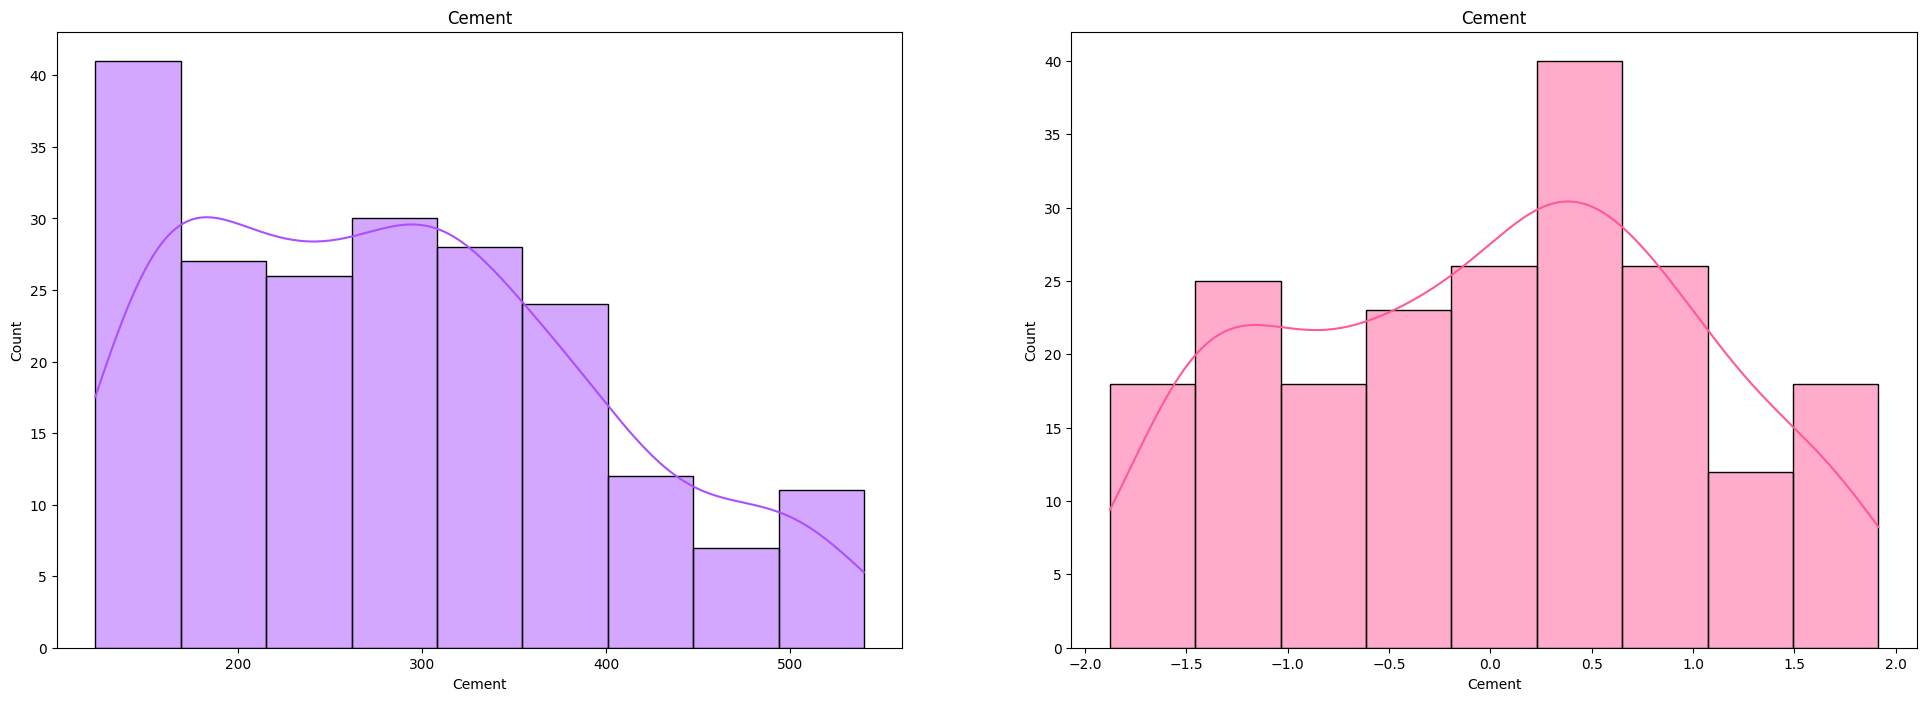

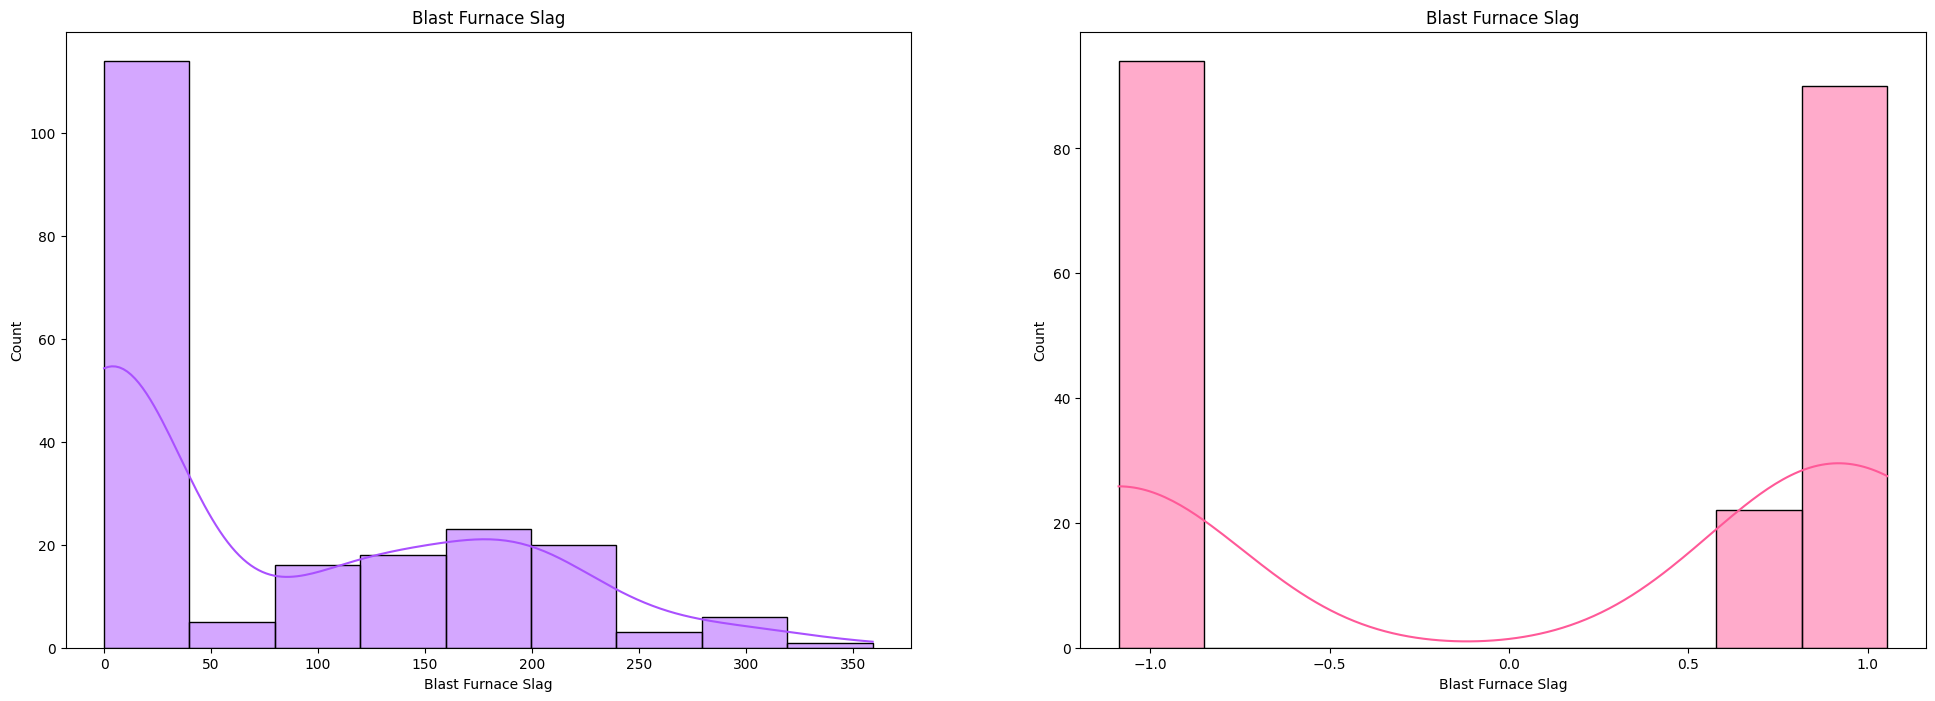

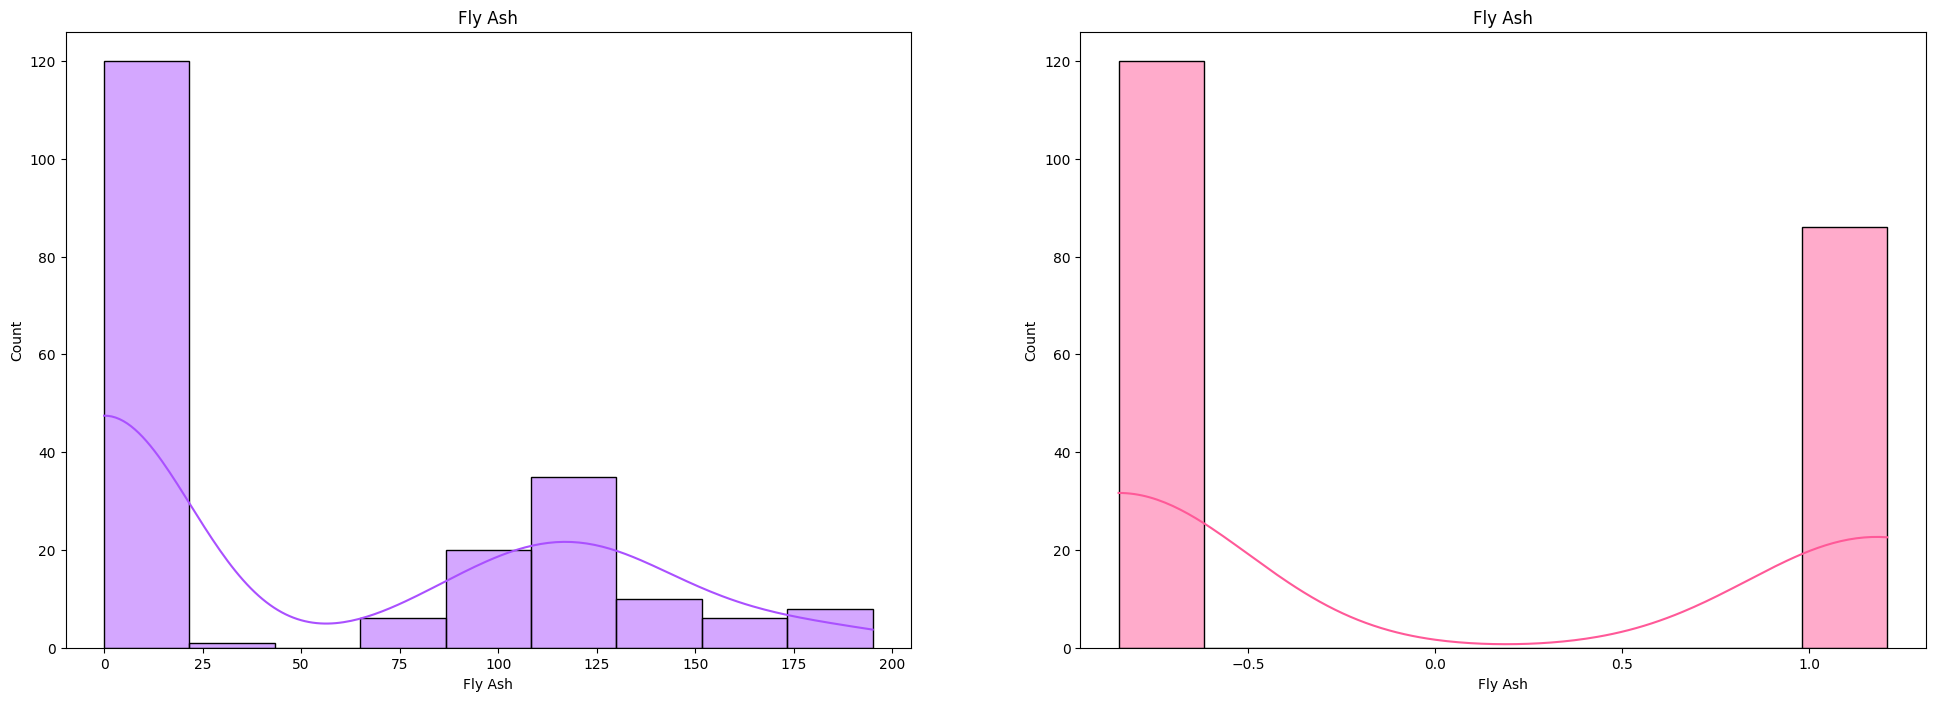

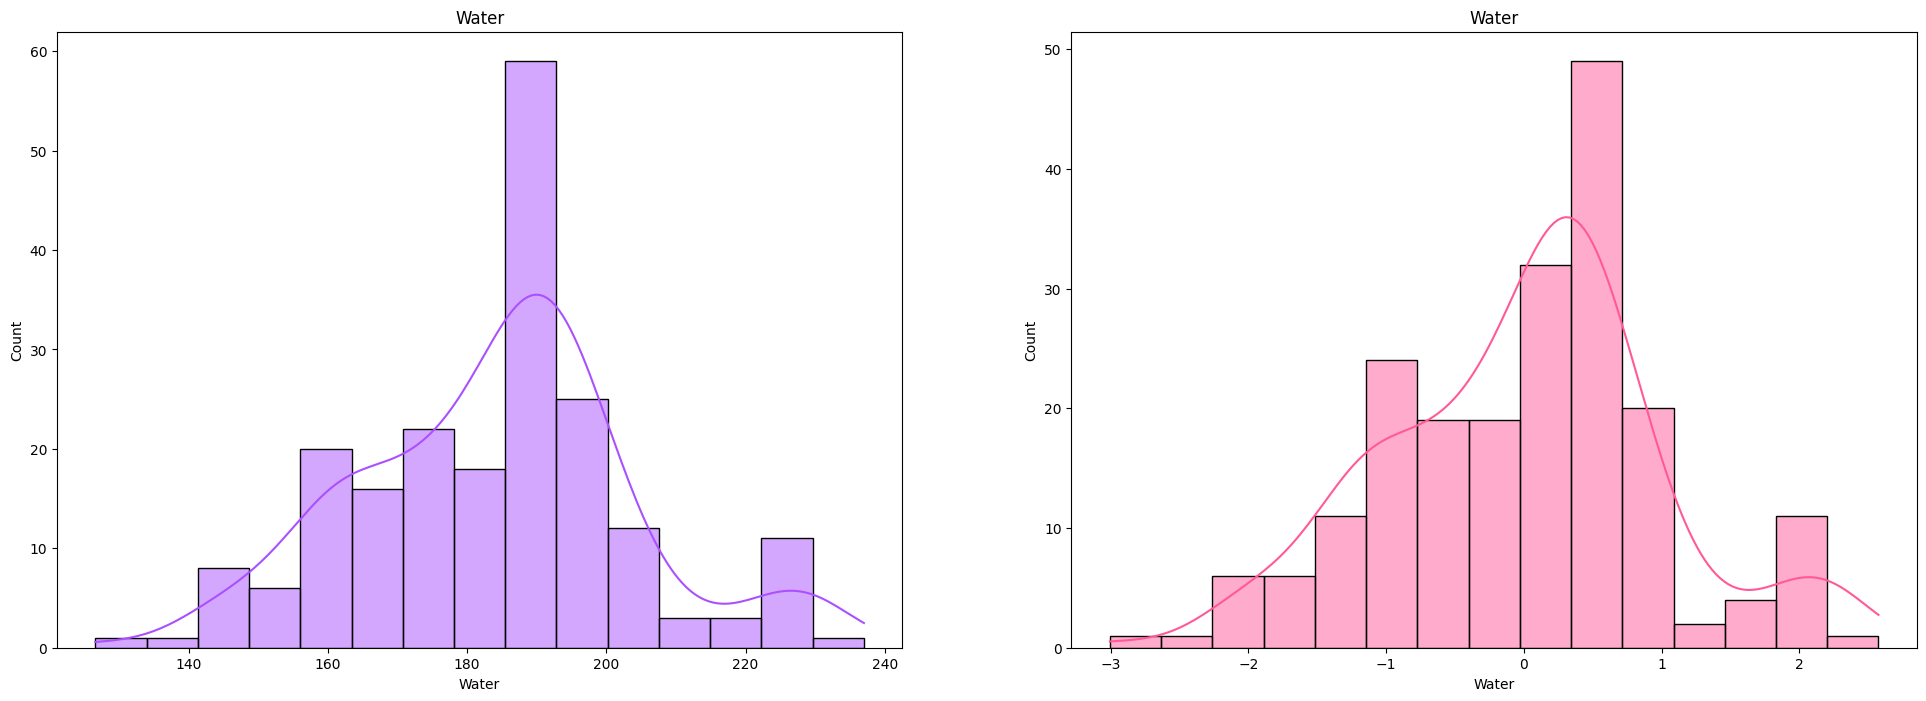

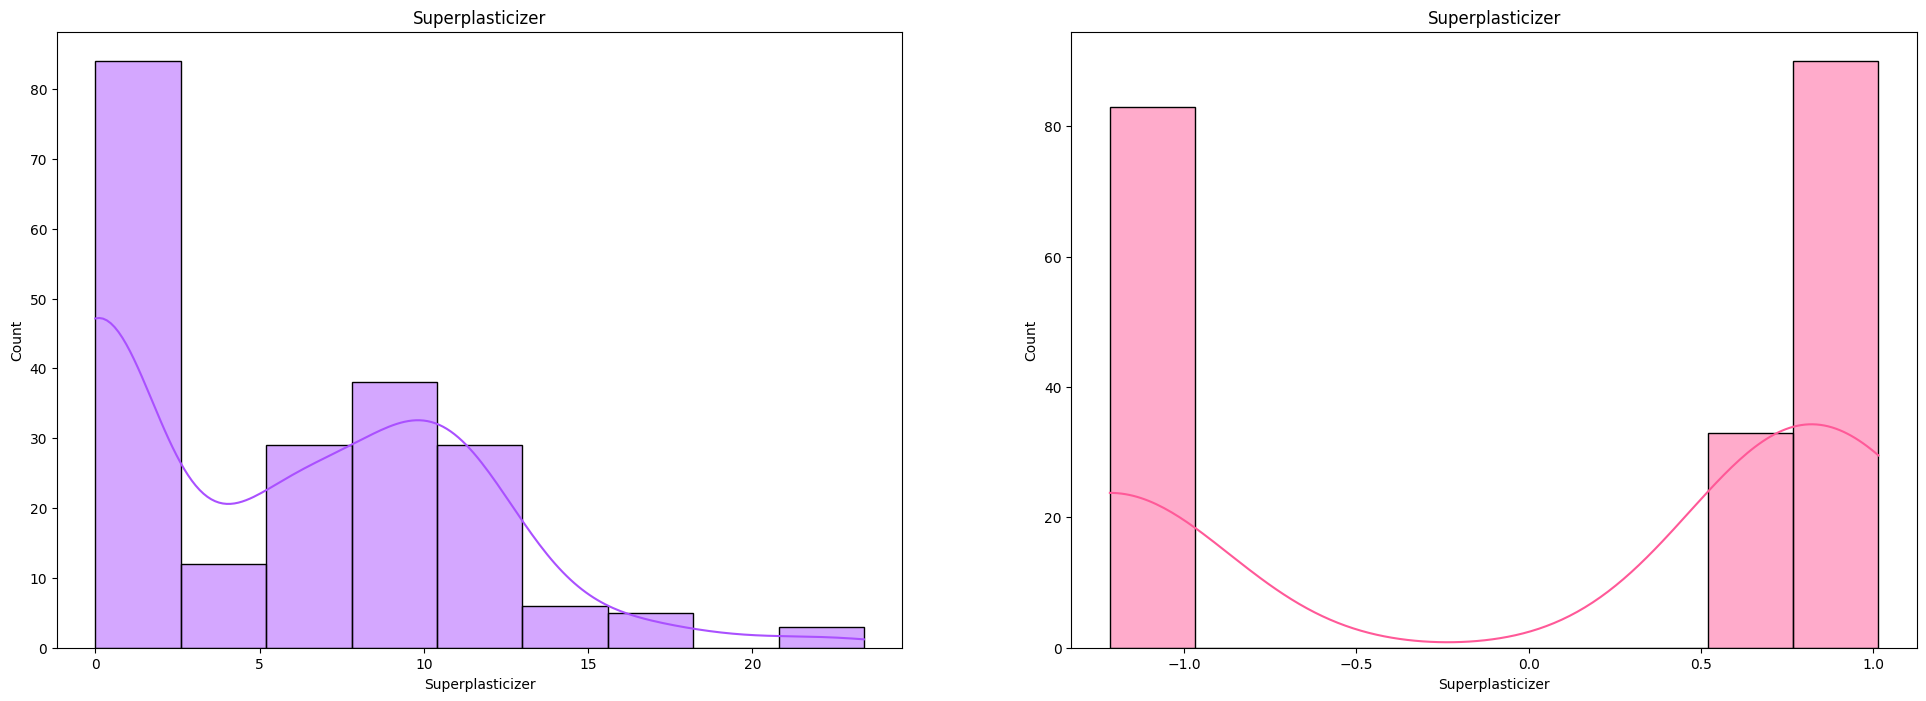

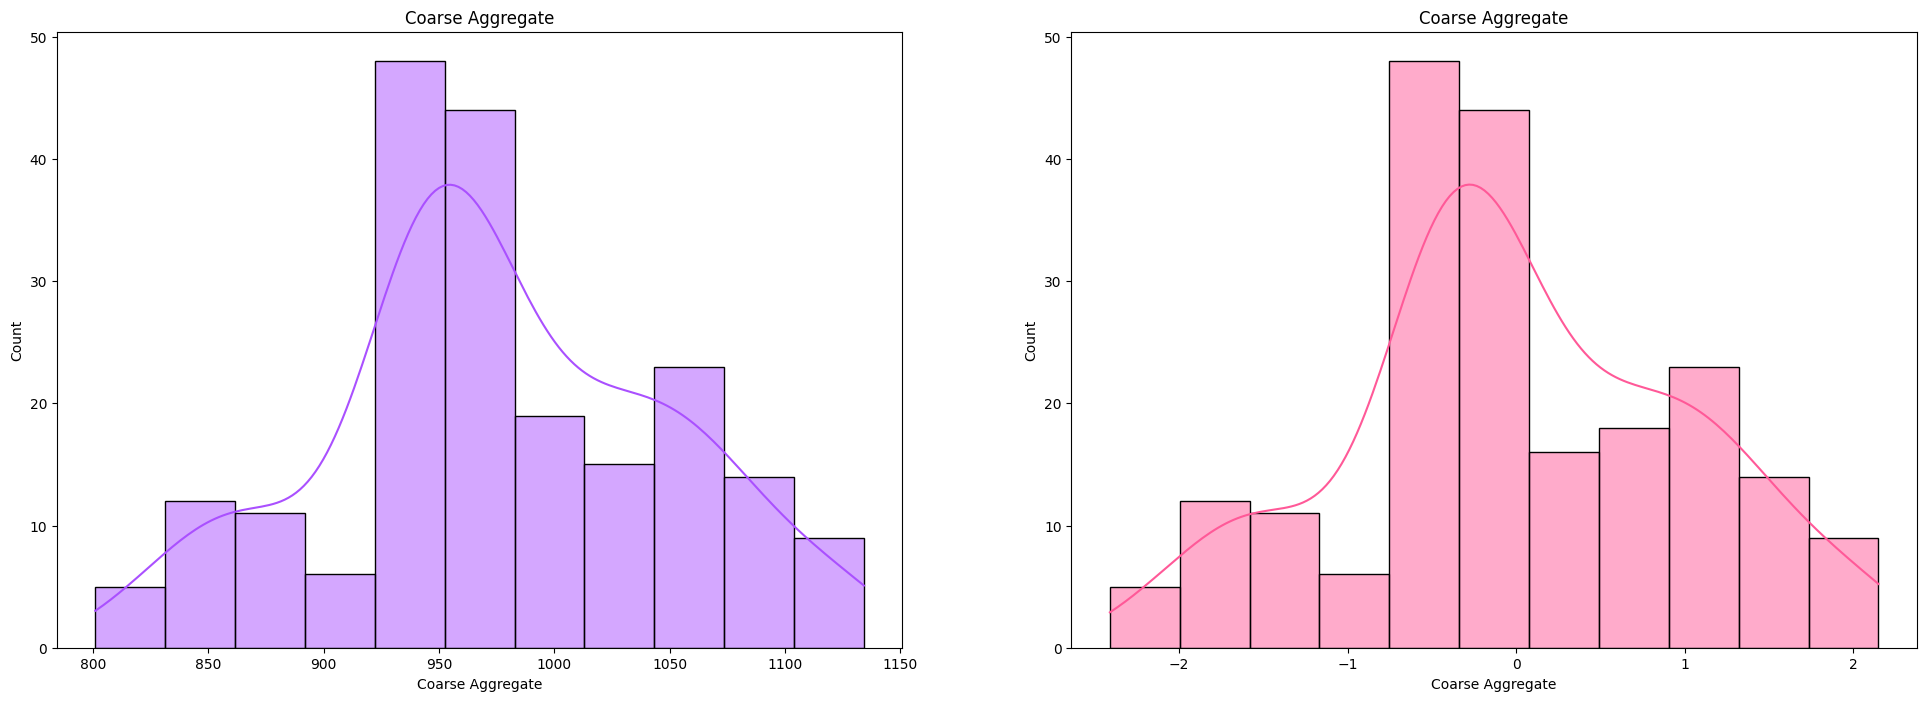

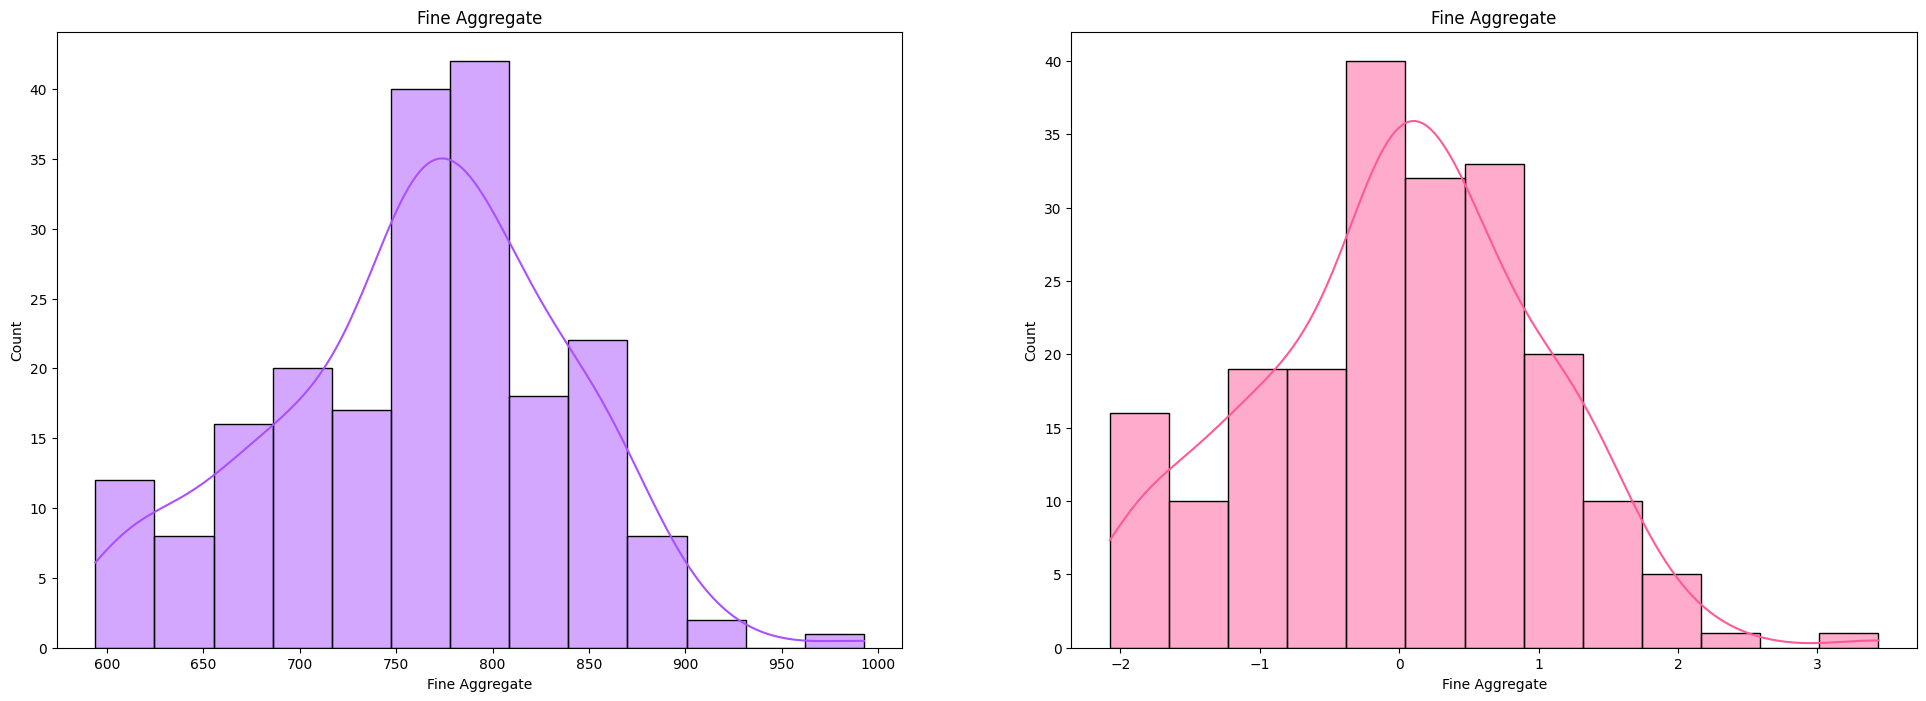

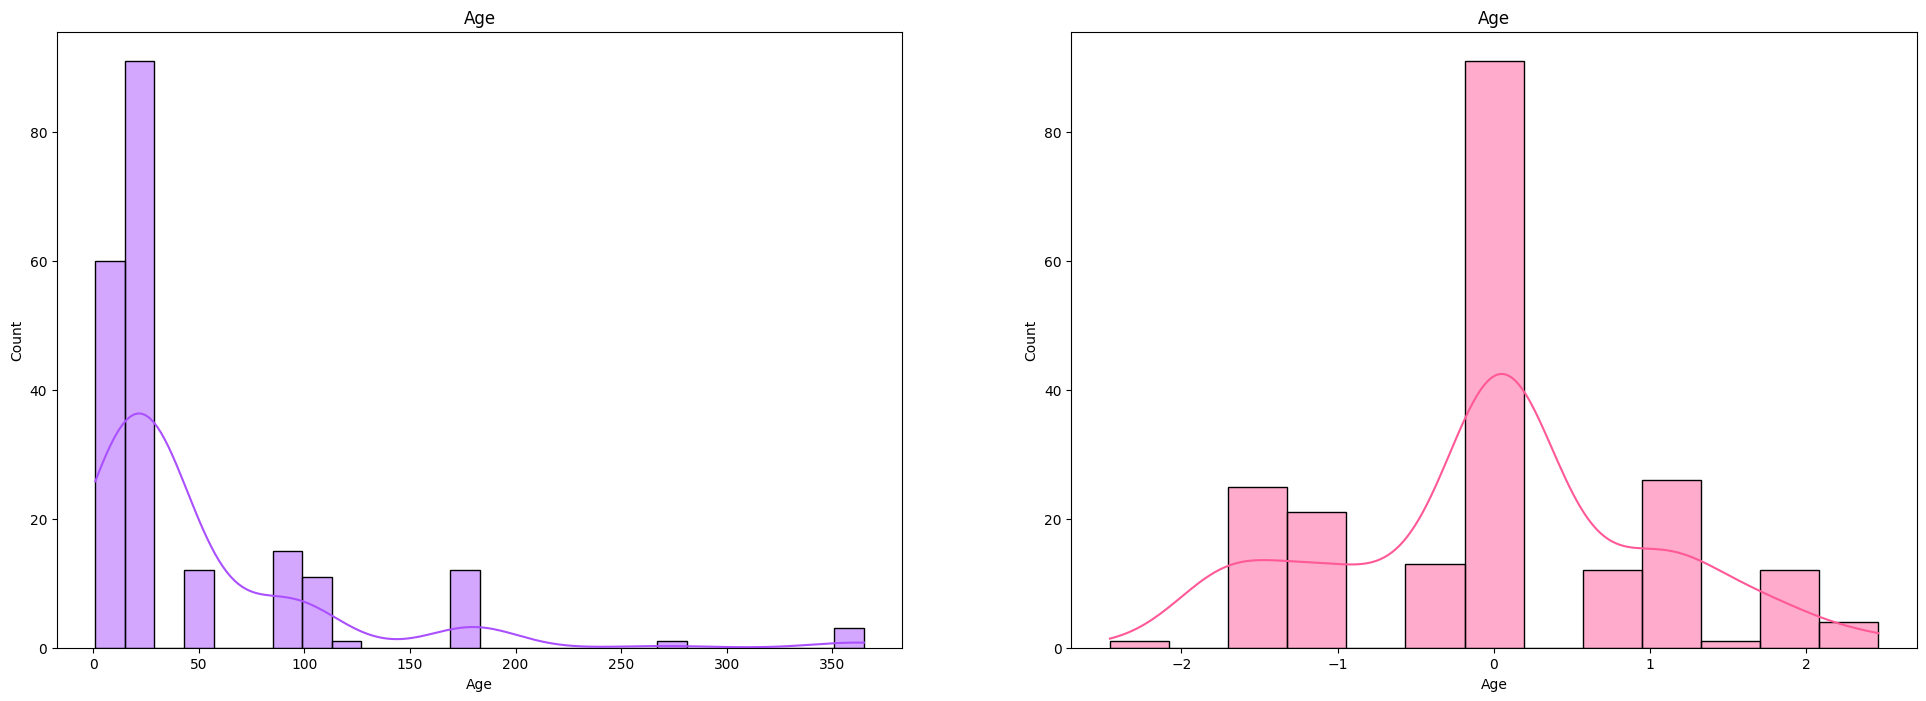

In [ ]:
xtrain_transformed = pd.DataFrame(xtrain_transformed,columns=xtrain.columns)

for col in xtrain_transformed.columns:
    plt.figure(figsize=(24,8))
    plt.subplot(121)
    sns.histplot(xtrain[col], kde=True, color="#aa50ff")
    plt.title(col)

    plt.subplot(122)
    sns.histplot(xtrain_transformed[col], kde=True, color="#ff5998")
    plt.title(col)

    plt.show()

### **Yoe johnson transformation**

In [19]:
yj_pt = PowerTransformer()

xtrain_transformed_yj = yj_pt.fit_transform(xtrain)
xtest_transformed_yj = yj_pt.transform(xtest)

lr.fit(xtrain_transformed_yj, ytrain)

ypred_yj = lr.predict(xtest_transformed_yj)

r2_score(ytest, ypred_yj)

0.8001052733112101

In [20]:
pd.DataFrame({'columns':xtrain.columns, 'lambda_values':yj_pt.lambdas_})

,columns,lambda_values
0,Cement,0.183144
1,Blast Furnace Slag,0.006660
2,Fly Ash,-0.214674
3,Water,0.732375
4,Superplasticizer,0.192539
5,Coarse Aggregate,0.837599
6,Fine Aggregate,1.830356
7,Age,0.025775


### **Before and after comparison**

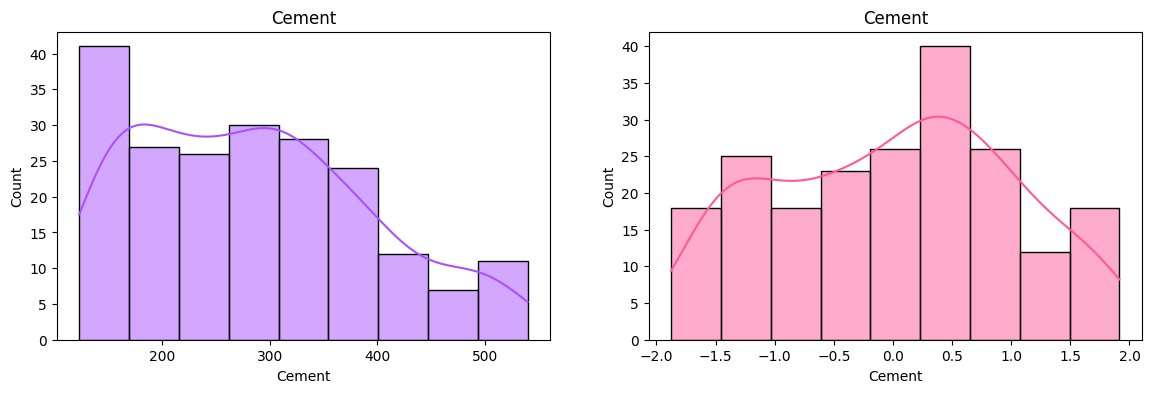

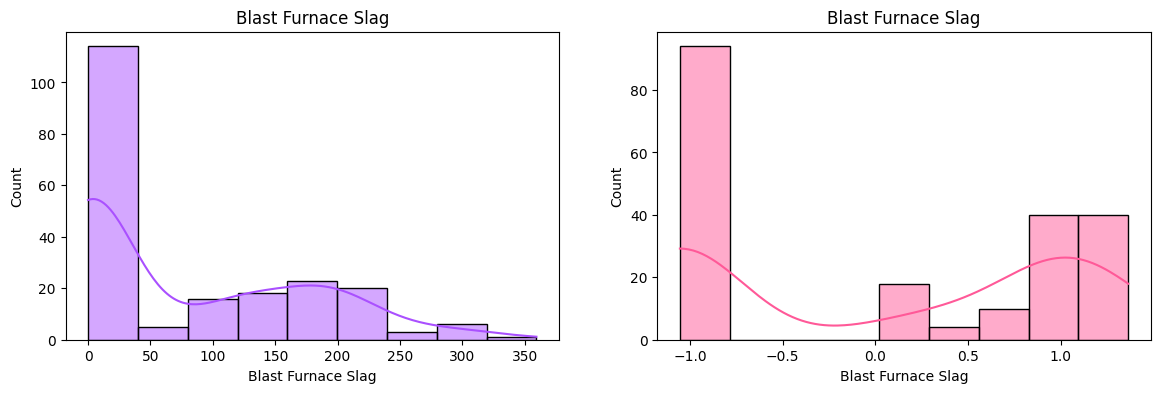

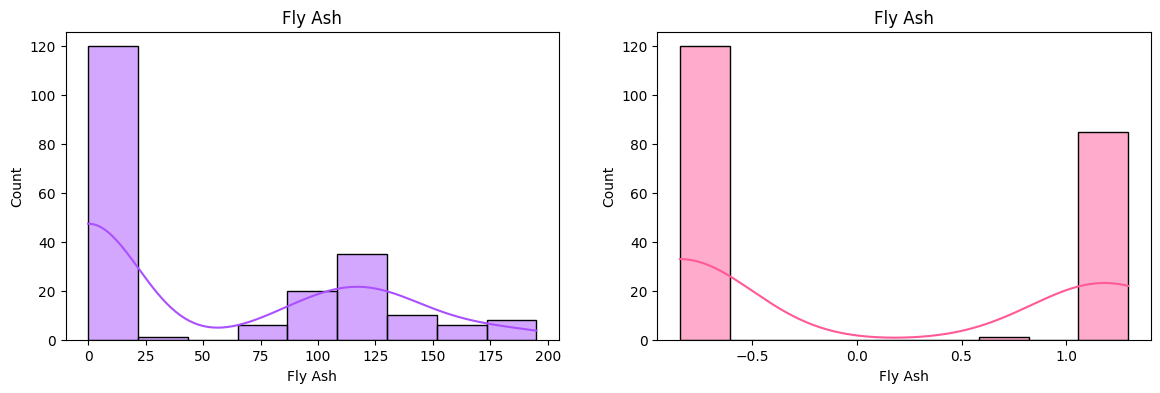

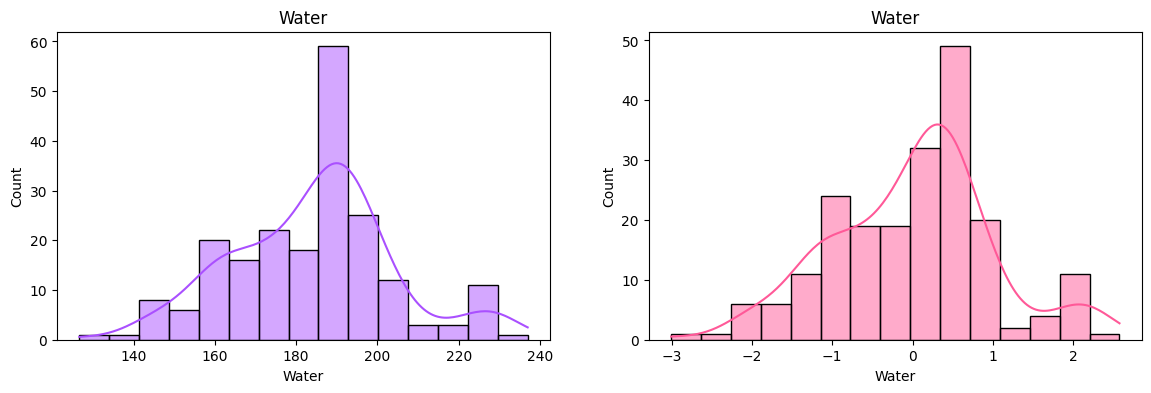

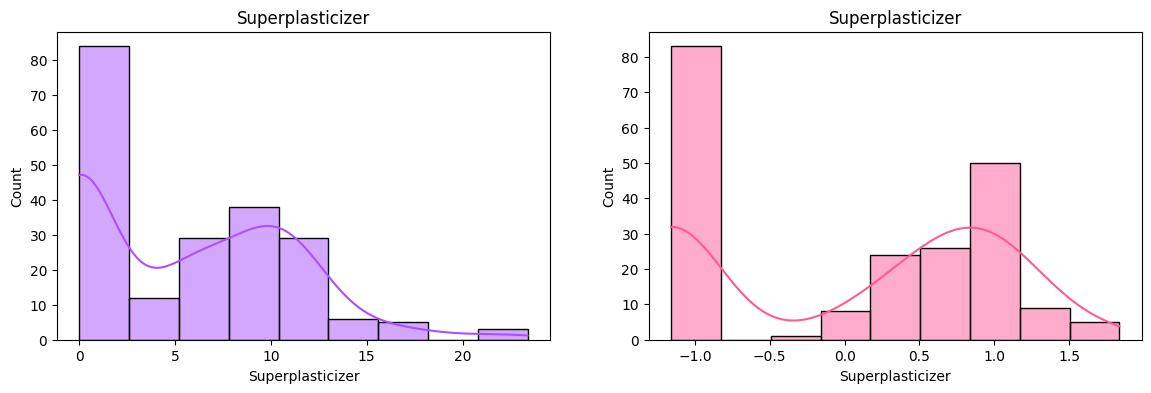

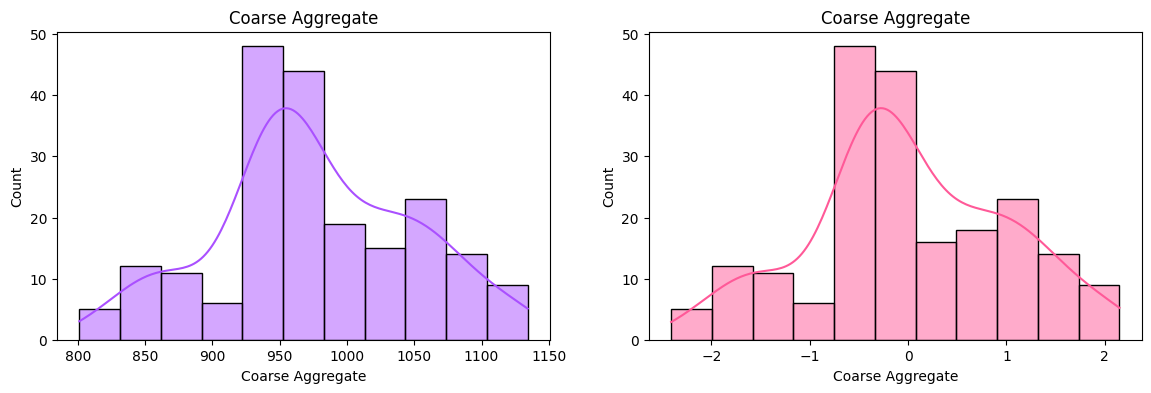

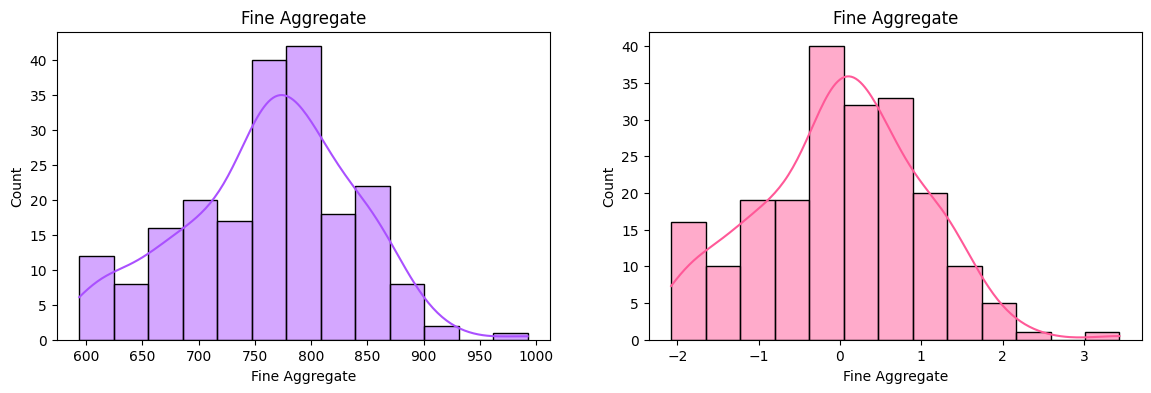

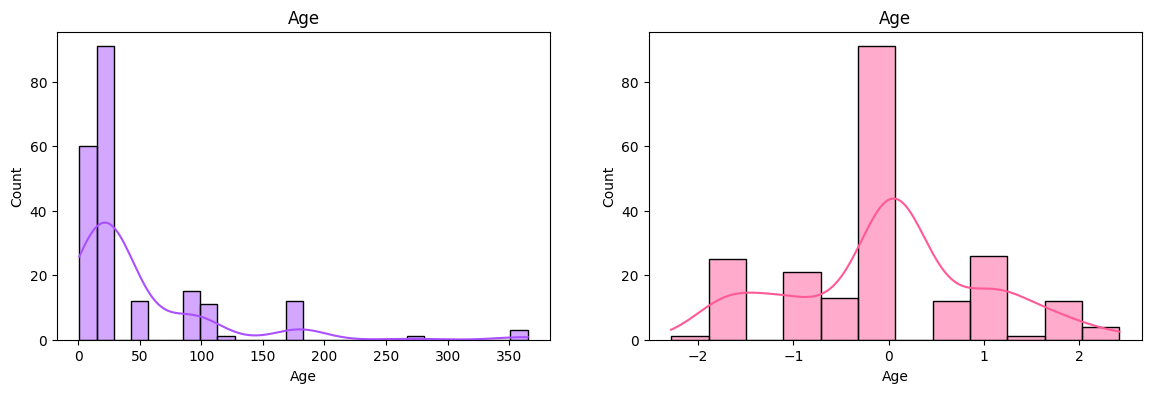

In [24]:
xtrain_transformed_yj = pd.DataFrame(xtrain_transformed_yj, columns=xtrain.columns)
for col in xtrain_transformed_yj.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.histplot(xtrain[col], kde=True, color="#aa50ff")
    plt.title(col)

    plt.subplot(122)
    sns.histplot(xtrain_transformed_yj[col], kde=True, color="#ff5998")
    plt.title(col)

    plt.show()